# Checkbook Analysis
## Process and graph data

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import functions as fn

In [2]:
# set default range for data query
current_date = pd.Timestamp.now()

# start_date can be set to zero to capture all data
# start_date = pd.to_datetime('2020-01-01')
# Default start_date set to January of prior year
start_date = (current_date - pd.offsets.DateOffset(years=1)).replace(month=1, day=1)
end_date = pd.Timestamp.now() + pd.Timedelta(days=365)

In [3]:
# set default aggregating threshold percentage for credit pie chart
# creditors that do not exceed this percentage in total will be combined to a single aggregated category
pie_cred_agg = 1.5

# set default aggregating threshold percentage for payee pie chart
# payees that do not exceed this percentage in total will be combined to a single aggregated category
pie_payee_agg = 2

# set default threshold percentage for pie chart explode
credit_explode_threshold = 35
payee_explode_threshold = 15

# set default number of payees to include in line graph
line_payee = 6

## Import and Review Data

In [4]:
# import data
df = pd.read_excel('Checkbook.xlsx', header = 1)

In [15]:
df.describe

<bound method NDFrame.describe of           Check #       Date Transaction Description  Payment ty   Credit  \
3698         Card 2023-01-04                 Walmart   145.59  X      NaN   
3699  Online Pymt 2023-01-04         West Penn Power   203.69  X      NaN   
3700         Card 2023-01-06            GetGo # 3122    66.29  X      NaN   
3701          Fee 2023-01-06          Service Charge     9.99  X      NaN   
3702         Card 2023-01-07    Allegheny Coffee Tea     9.12  X      NaN   
...           ...        ...                     ...      ... ..      ...   
4138         Card 2024-02-18  Picante Mexican Grille    25.00  X      NaN   
4139         Card 2024-02-20  Picante Mexican Grille    19.50  X      NaN   
4140         Card 2024-02-23            GetGo # 3122    43.93  X      NaN   
4141         Card 2024-02-24  Picante Mexican Grille    26.27  X      NaN   
4142      Deposit 2024-02-28    Check Deposit - MUFP      NaN  X  1489.64   

       Balance  
3698   8414.68  
3699   

In [6]:
df.describe()

,Date,Payment,Credit,Balance
count,4143,3844.000000,299.000000,4143.000000
mean,2019-04-14 11:05:15.423606016,115.429123,1521.736488,8973.967820
min,2014-03-06 00:00:00,0.020000,4.000000,1027.350000
25%,2016-11-14 00:00:00,23.127500,1489.640000,5355.725000
50%,2019-03-12 00:00:00,44.335000,1584.400000,7443.160000
75%,2021-08-02 00:00:00,100.000000,1677.120000,12226.890000
max,2024-02-28 00:00:00,20000.000000,5251.530000,24272.850000
std,NaN,399.821956,738.866754,4794.451333


## Filter Primary Dataframes

In [7]:
# filter df for desired date range
df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
df.head()

,Check #,Date,Transaction Description,Payment,ty,Credit,Balance
3698,Card,2023-01-04,Walmart,145.59,X,NaN,8414.68
3699,Online Pymt,2023-01-04,West Penn Power,203.69,X,NaN,8210.99
3700,Card,2023-01-06,GetGo # 3122,66.29,X,NaN,8144.70
3701,Fee,2023-01-06,Service Charge,9.99,X,NaN,8134.71
3702,Card,2023-01-07,Allegheny Coffee Tea,9.12,X,NaN,8125.59


In [8]:
# create df for creditors and payees to group the two separately and clean them up for further processing
creditor_df, payee_df = fn.sep_trans(df)

In [9]:
payee_df.head()

,Check #,Date,Transaction Description,Amount
3698,Card,2023-01-04,Walmart,145.59
3699,Online Pymt,2023-01-04,West Penn Power,203.69
3700,Card,2023-01-06,GetGo # 3122,66.29
3701,Fee,2023-01-06,Service Charge,9.99
3702,Card,2023-01-07,Allegheny Coffee Tea,9.12


In [10]:
creditor_df.describe()

,Date,Amount
count,30,30.000000
mean,2023-08-02 14:24:00,1541.571000
min,2023-01-15 00:00:00,437.210000
25%,2023-04-18 18:00:00,1489.640000
50%,2023-07-24 12:00:00,1489.640000
75%,2023-11-11 00:00:00,1489.640000
max,2024-02-28 00:00:00,4100.000000
std,NaN,519.969607


In [11]:
payee_df.describe()

,Date,Amount
count,415,415.000000
mean,2023-07-25 16:53:12.289156864,85.860723
min,2023-01-04 00:00:00,1.500000
25%,2023-04-15 12:00:00,19.195000
50%,2023-07-17 00:00:00,36.370000
75%,2023-10-31 12:00:00,83.890000
max,2024-02-24 00:00:00,1951.400000
std,NaN,178.772592


In [12]:
# get summary for creditors and payees
creditor_summary = fn.summary(creditor_df)
payee_summary = fn.summary(payee_df)

# Print top 10 payees
payee_summary.head(10)

,Transaction Description,num_tran,total_amt,avg_tran
0,Chase Amazon Credit Card,13,12072.73,928.67
1,Walmart,49,5074.77,103.57
2,Comcast,13,2730.31,210.02
3,Picante Mexican Grille,115,2561.39,22.27
4,Fine Goods & Services,46,2265.26,49.24
5,West Penn Power,14,2039.92,145.71
6,Verizon Wireless,13,1943.82,149.52
7,GetGo # 3122,28,1564.32,55.87
8,Penn Twp Sewage Authority,5,840.53,168.11
9,Peoples Natural Gas,12,552.08,46.01


## Create Pie Charts for Inflows and Outflows

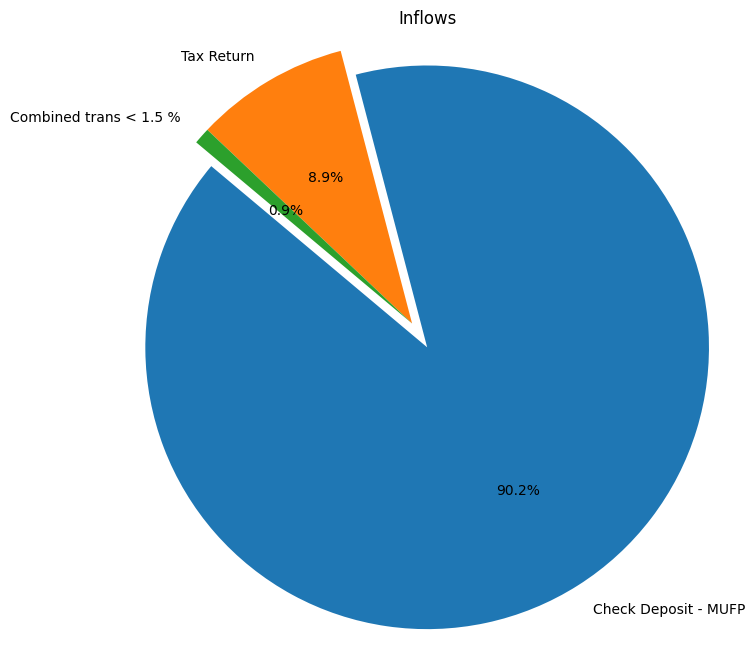

In [13]:
pie_inflows = fn.pie_chart(creditor_summary, pie_cred_agg, credit_explode_threshold, 'Inflows')
pie_inflows.show()

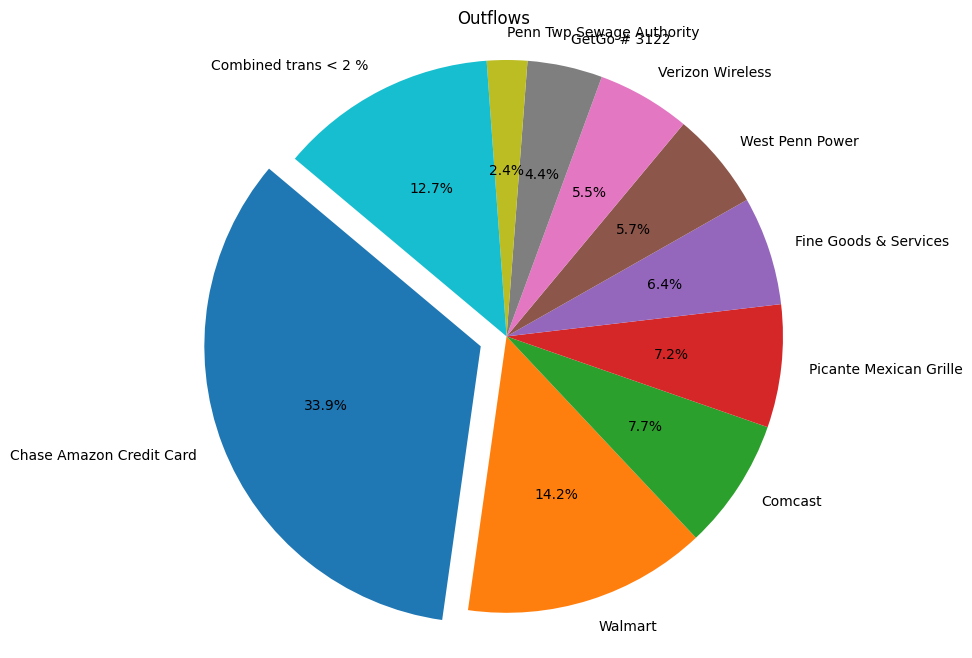

In [14]:
pie_outflows = fn.pie_chart(payee_summary, pie_payee_agg, payee_explode_threshold, 'Outflows')
pie_outflows.show()

## Create histogram of monthly inflows/outflows

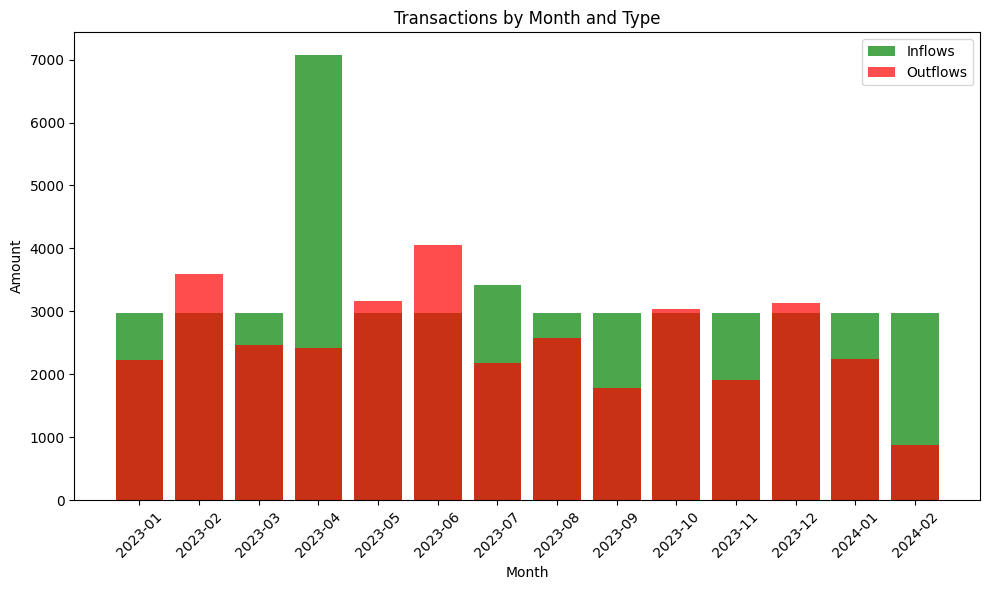

In [15]:
# calculate number of months covered by data
last_date = max(creditor_df['Date'].max(), payee_df['Date'].max())
num_month = (last_date.year - start_date.year) * 12 + (last_date.month - start_date.month) + 1

# get histogram
histogram = fn.histogram(creditor_df, payee_df, num_month)
histogram.show()

## Create Line Graph of Top Outflows Over Time

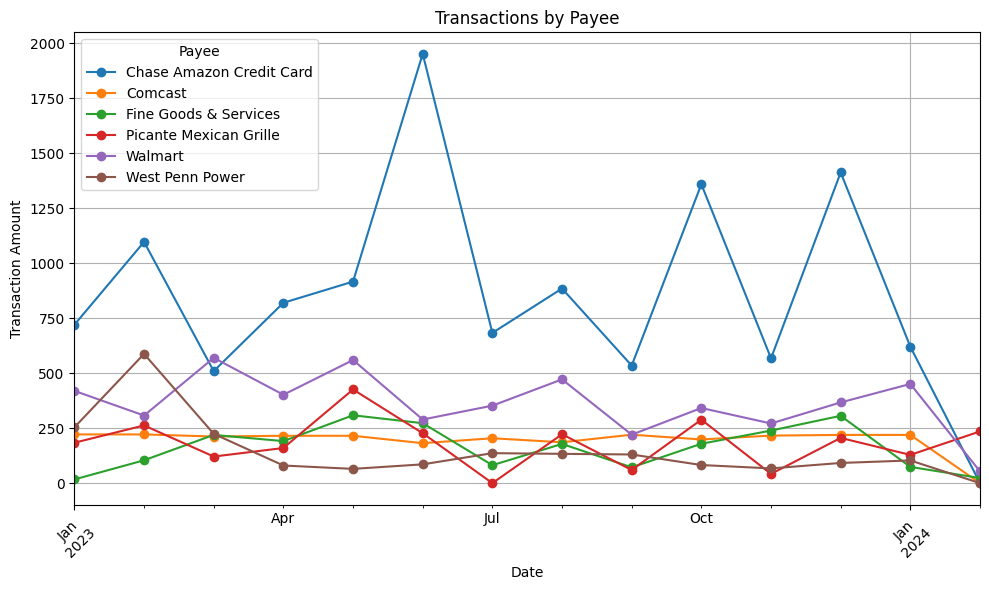

In [16]:
# send values for line_graph function
line_outflows = fn.line_graph(payee_summary, payee_df, line_payee, True)
line_outflows.show()